In [1]:
import getpass
import os
from langchain.chat_models import init_chat_model

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")
llm = init_chat_model("gemini-2.5-flash-preview-04-17", model_provider="google_genai", temperature=0)

In [18]:
import re
from langchain.document_loaders import WebBaseLoader
from langchain_community.tools import DuckDuckGoSearchResults
def download_web_pages(query: str) -> str:
    """
    Performs a web search using the given query, downloads the content of two relevant web pages,
    and returns their combined content as a raw string.

    This is useful when the task requires analysis of web page content, such as retrieving poems, 
    changelogs, or other textual resources.

    Args:
        query (str): The search query.

    Returns:
        str: The combined raw text content of the two retrieved web pages.
    """
    search_engine = DuckDuckGoSearchResults(output_format="list", num_results=2)
    page_urls = [url["link"] for url in search_engine(query)]

    loader = WebBaseLoader(web_paths=(page_urls))
    docs = loader.load()

    combined_text = "\n\n".join(doc.page_content[:15000] for doc in docs)

    # Clean up excessive newlines, spaces and strip leading/trailing whitespace
    cleaned_text = re.sub(r'\n{3,}', '\n\n', combined_text).strip()
    cleaned_text = re.sub(r'[ \t]{6,}', ' ', cleaned_text)

    # Strip leading/trailing whitespace
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [24]:
from langchain_community.retrievers import WikipediaRetriever

def wikipedia_search(query: str) -> str:
    """
    Searches for a Wikipedia articles using the provided query and returns the content of the corresponding Wikipedia pages.

    Args:
        query (str): The search term to look up on Wikipedia.

    Returns:
        str: The text content of the Wikipedia articles related to the query.
    """
    retriever = WikipediaRetriever()
    docs = retriever.invoke(query)
    combined_text = "\n\n".join(doc.page_content for doc in docs)
    return combined_text

In [25]:
from google import genai
from google.genai import types

def youtube_viewer(youtube_url: str, question: str) -> str:
    """
    Analyzes a YouTube video from the provided URL and returns an answer 
    to the given question based on the analysis results.

    Args:
        youtube_url (str): The URL of the YouTube video, in the format 
            "https://www.youtube.com/...".
        question (str): A question related to the content of the video.

    Returns:
        str: An answer to the question based on the video's content.
    """
    client = genai.Client()
    response = client.models.generate_content(
        model='models/gemini-2.5-flash-preview-04-17',
        contents=types.Content(
            parts=[
                types.Part(
                    file_data=types.FileData(file_uri=youtube_url)
                ),
                types.Part(text=question)
            ]
        )
    )
    return response.text

In [26]:
tools = [download_web_pages, wikipedia_search, youtube_viewer]

# Bind the tools to the agent
llm_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [27]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """Agent state for the graph."""
    input_file: Optional[str]
    messages: Annotated[list[AnyMessage], add_messages]

In [28]:
from langchain_core.messages import SystemMessage, HumanMessage

def assistant(state: AgentState):
  sys_msg = SystemMessage(
    content=
    """
You are a helpful assistant tasked with answering questions using a set of tools. When given a question, follow these steps:
1. Create a clear, step-by-step plan to solve the question.
2. If a tool is necessary, select the most appropriate tool based on its functionality. If one tool isn't working, use another with similar functionality.
3. Execute your plan and provide the response in the following format:

FINAL ANSWER: [YOUR FINAL ANSWER]

Your final answer should be:

- A number (without commas or units unless explicitly requested),
- A short string (avoid articles, abbreviations, and use plain text for digits unless otherwise specified),
- A comma-separated list (apply the formatting rules above for each element, with exactly one space after each comma).

Ensure that your answer is concise and follows the task instructions strictly. If the answer is more complex, break it down in a way that follows the format.
Begin your response with "FINAL ANSWER: " followed by the answer, and nothing else.
    """
  )

  return {
    "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    "input_file": state["input_file"]
  }

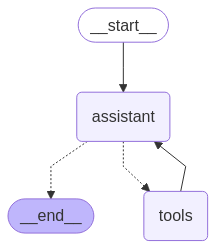

In [29]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Build the state graph
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()
# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
from huggingface_hub import login

# This will prompt you for your token
login()

In [12]:
from huggingface_hub import whoami

info = whoami()
username = info["name"]

print(f"Logged in as: {username}")

Logged in as: SpyFox


In [13]:
DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"    
api_url = DEFAULT_API_URL
questions_url = f"{api_url}/questions"
submit_url = f"{api_url}/submit"
files_url = f"{api_url}/files"

In [14]:
import requests
print(f"Fetching questions from: {questions_url}")
try:
    response = requests.get(questions_url, timeout=15)
    response.raise_for_status()
    questions_data = response.json()
    if not questions_data:
          print("Fetched questions list is empty.")
    print(f"Fetched {len(questions_data)} questions.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching questions: {e}")
except requests.exceptions.JSONDecodeError as e:
      print(f"Error decoding JSON response from questions endpoint: {e}")
      print(f"Response text: {response.text[:500]}")
except Exception as e:
    print(f"An unexpected error occurred fetching questions: {e}")

print(questions_data[7])

Fetching questions from: https://agents-course-unit4-scoring.hf.space/questions
Fetched 20 questions.
{'task_id': 'cabe07ed-9eca-40ea-8ead-410ef5e83f91', 'question': "What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?", 'Level': '1', 'file_name': ''}


In [30]:
import time

def extract_after_final_answer(text):
    keyword = "FINAL ANSWER: "
    index = text.find(keyword)
    if index != -1:
        return text[index + len(keyword):]
    else:
        return ""

answers_payload = []

print(f"Running agent on {len(questions_data)} questions...")
for item in questions_data:
    task_id = item.get("task_id")
    question_text = item.get("question")
    print(f"Question: {question_text}")
    messages = [HumanMessage(content=question_text)]

    if not task_id or question_text is None:
        print(f"Skipping item with missing task_id or question: {item}")
        continue
    try:
        submitted_answer = react_graph.invoke({"messages": messages, "input_file": None})
        submitted_answer = extract_after_final_answer(submitted_answer['messages'][-1].content)
        print(f"Answer: {submitted_answer}")
        answers_payload.append({"task_id": task_id, "submitted_answer": submitted_answer})
        time.sleep(10)  # Sleep for 10 seconds to avoid rate limiting
    except Exception as e:
        print(f"Error running agent on task {task_id}: {e}")


Running agent on 20 questions...
Question: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.


C:\Users\wasyl\AppData\Local\Temp\ipykernel_22488\81366616.py:19: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  page_urls = [url["link"] for url in search_engine(query)]


Answer: 3
Question: In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
Answer: 3


KeyboardInterrupt: 

In [27]:
submission_data = {"username": username.strip(), "agent_code": "https://huggingface.co/spaces/SpyFox/agents_final_test/tree/main", "answers": answers_payload}
status_update = f"Agent finished. Submitting {len(answers_payload)} answers for user '{username}'..."
print(status_update)

Agent finished. Submitting 20 answers for user 'SpyFox'...


In [28]:
print(f"Submitting {len(answers_payload)} answers to: {submit_url}")

response = requests.post(submit_url, json=submission_data, timeout=60)
response.raise_for_status()
result_data = response.json()
final_status = (
    f"Submission Successful!\n"
    f"User: {result_data.get('username')}\n"
    f"Overall Score: {result_data.get('score', 'N/A')}% "
    f"({result_data.get('correct_count', '?')}/{result_data.get('total_attempted', '?')} correct)\n"
    f"Message: {result_data.get('message', 'No message received.')}"
)
print("Submission successful.")
print(final_status)

Submitting 20 answers to: https://agents-course-unit4-scoring.hf.space/submit
Submission successful.
Submission Successful!
User: SpyFox
Overall Score: 45.0% (9/20 correct)
Message: Score calculated successfully: 9/20 total questions answered correctly (20 valid tasks attempted). High score updated on leaderboard.
